Circuit netlist:
.title Regulated Power Supply Circuit
Vpri primary 0 DC 0V AC 1V SIN(0V 339.41V 50Hz 0s 0Hz)
Esec_p sec_plus 0 primary 0 0.05
Esec_n sec_minus 0 0 primary 0.05
Rsec_r1 sec_plus sec_plus_r 0.1Ohm
Rsec_r2 sec_minus sec_minus_r 0.1Ohm
DD1 sec_plus_r smooth DiodeModel
DD2 0 sec_plus_r DiodeModel
DD3 0 sec_minus_r DiodeModel
DD4 sec_minus_r smooth DiodeModel
Cfilter smooth 0 1000uF
Rseries smooth reg_input 100Ohm
Dzener 0 output ZenerModel
Rreg1 reg_input output 50Ohm
Rreg2 output 0 200Ohm
Rload output 0 1kOhm
.model DiodeModel D (Is=1e-14A Rs=0.1Ohm n=1.0)
.model ZenerModel D (Bv=5.1V Ibv=10mA Is=1e-14A Rs=1Ohm)



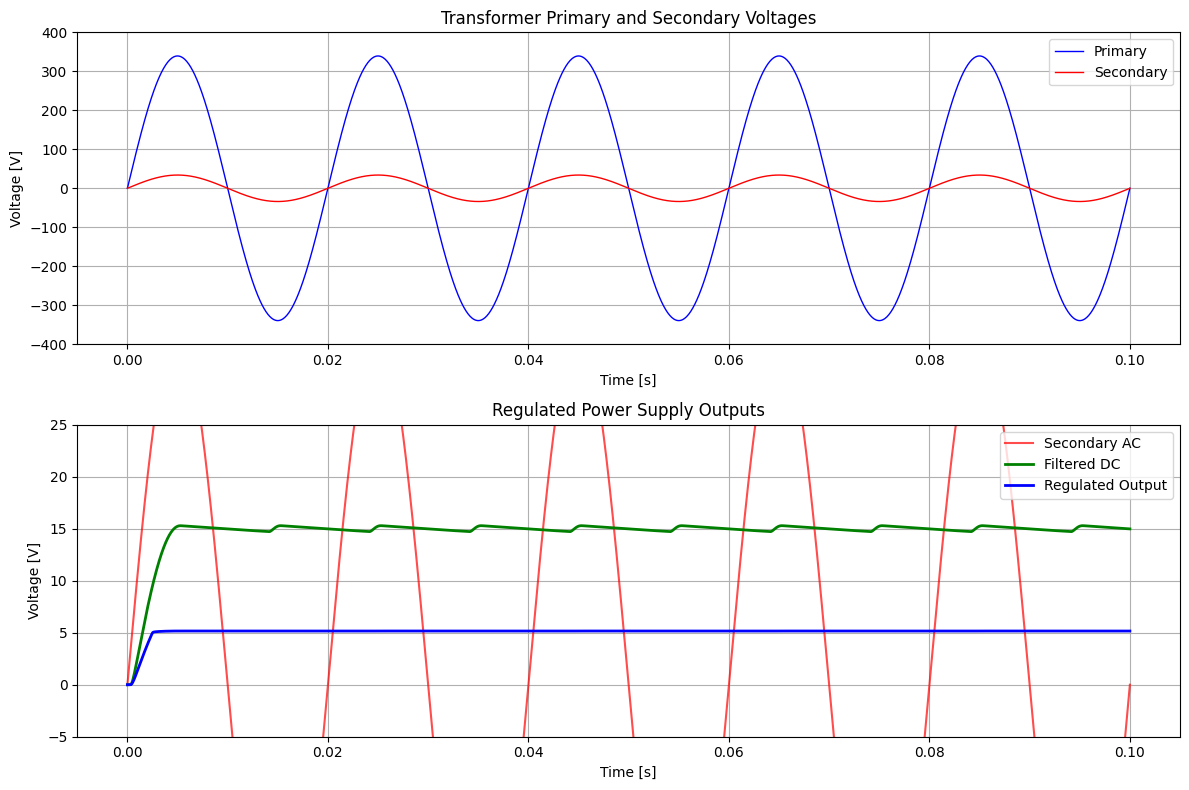


Circuit Analysis:
Input voltage (RMS): 240.0 V
Expected secondary (RMS): 12.0 V
Final output voltage: 5.17 V


In [2]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
import numpy as np
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()
from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

# Create the main circuit
circuit = Circuit('Regulated Power Supply Circuit')

# Primary voltage source (240V RMS = 339.41V peak)
source = circuit.SinusoidalVoltageSource('pri', 'primary', circuit.gnd, amplitude=339.41@u_V, frequency=50@u_Hz)

# Transformer model using ideal transformer approach
# Turn ratio 20:1 (240V primary to 12V secondary RMS)
turn_ratio = 20

# Create center-tapped secondary using voltage sources
# Secondary voltage = Primary voltage / turn_ratio
# Center-tapped means we get +V and -V from center (ground)
circuit.VoltageControlledVoltageSource('sec_p', 'sec_plus', circuit.gnd, 'primary', circuit.gnd, 1/turn_ratio)
circuit.VoltageControlledVoltageSource('sec_n', 'sec_minus', circuit.gnd, circuit.gnd, 'primary', 1/turn_ratio)

# Add small series resistance to secondary for realism
circuit.R('sec_r1', 'sec_plus', 'sec_plus_r', 0.1@u_Ω)
circuit.R('sec_r2', 'sec_minus', 'sec_minus_r', 0.1@u_Ω)

# Bridge rectifier using built-in diode model
circuit.model('DiodeModel', 'D', Is=1e-14@u_A, Rs=0.1@u_Ω, n=1.0)

circuit.D('D1', 'sec_plus_r', 'smooth', model='DiodeModel')
circuit.D('D2', circuit.gnd, 'sec_plus_r', model='DiodeModel')
circuit.D('D3', circuit.gnd, 'sec_minus_r', model='DiodeModel')
circuit.D('D4', 'sec_minus_r', 'smooth', model='DiodeModel')

# Filter capacitor
circuit.C('filter', 'smooth', circuit.gnd, 1000@u_uF)

# Series resistor for current limiting
circuit.R('series', 'smooth', 'reg_input', 100@u_Ω)

# Zener diode for voltage regulation (5.1V)
circuit.model('ZenerModel', 'D', Is=1e-14@u_A, Rs=1@u_Ω, Bv=5.1@u_V, Ibv=10@u_mA)
circuit.D('zener', circuit.gnd, 'output', model='ZenerModel')

# Voltage divider for regulation
circuit.R('reg1', 'reg_input', 'output', 50@u_Ω)
circuit.R('reg2', 'output', circuit.gnd, 200@u_Ω)

# Load resistor
circuit.R('load', 'output', circuit.gnd, 1@u_kΩ)

# Print circuit for debugging
print("Circuit netlist:")
print(circuit)

# Run simulation with more conservative settings
try:
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    
    # Use more conservative simulation parameters
    analysis = simulator.transient(step_time=10@u_us, end_time=100@u_ms)
    
    # Plot results
    figure, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # First subplot - Primary and Secondary
    ax1.set_title('Transformer Primary and Secondary Voltages')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Voltage [V]')
    ax1.grid(True)
    
    time_values = np.array(analysis.time)
    primary_values = np.array(analysis['primary'])
    secondary_values = np.array(analysis['sec_plus']) - np.array(analysis['sec_minus'])
    
    ax1.plot(time_values, primary_values, 'b-', label='Primary', linewidth=1)
    ax1.plot(time_values, secondary_values, 'r-', label='Secondary', linewidth=1)
    ax1.legend(loc='upper right')
    ax1.set_ylim(-400, 400)
    
    # Second subplot - Power supply outputs
    ax2.set_title('Regulated Power Supply Outputs')
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Voltage [V]')
    ax2.grid(True)
    
    smooth_values = np.array(analysis['smooth'])
    output_values = np.array(analysis['output'])
    
    ax2.plot(time_values, secondary_values, 'r-', label='Secondary AC', alpha=0.7)
    ax2.plot(time_values, smooth_values, 'g-', label='Filtered DC', linewidth=2)
    ax2.plot(time_values, output_values, 'b-', label='Regulated Output', linewidth=2)
    ax2.legend(loc='upper right')
    ax2.set_ylim(-5, 25)
    
    # Add cursor to second subplot
    cursor = Cursor(ax2, useblit=True, color='red', linewidth=1)
    
    plt.tight_layout()
    plt.show()
    
    # Print some analysis
    print(f"\nCircuit Analysis:")
    print(f"Input voltage (RMS): {339.41/np.sqrt(2):.1f} V")
    print(f"Expected secondary (RMS): {339.41/np.sqrt(2)/turn_ratio:.1f} V")
    print(f"Final output voltage: {np.mean(output_values[-1000:]):.2f} V")
    
except Exception as e:
    print(f"Simulation error: {e}")
    print("\nTrying simplified version...")
    
    # Fallback: simplified circuit without transformer
    simple_circuit = Circuit('Simple Rectifier')
    
    # Direct AC source at secondary level
    simple_circuit.SinusoidalVoltageSource('ac', 'ac_in', simple_circuit.gnd, 
                                         amplitude=339.41/turn_ratio@u_V, frequency=50@u_Hz)
    
    # Simple rectifier
    simple_circuit.model('DiodeModel', 'D', Is=1e-14@u_A, Rs=0.1@u_Ω)
    simple_circuit.D('D1', 'ac_in', 'dc_out', model='DiodeModel')
    simple_circuit.C('filter', 'dc_out', simple_circuit.gnd, 1000@u_uF)
    simple_circuit.R('load', 'dc_out', simple_circuit.gnd, 1@u_kΩ)
    
    sim = simple_circuit.simulator()
    analysis = sim.transient(step_time=10@u_us, end_time=100@u_ms)
    
    plt.figure(figsize=(10, 6))
    plt.title('Simplified Rectifier Circuit')
    plt.xlabel('Time [s]')
    plt.ylabel('Voltage [V]')
    plt.grid(True)
    
    time_vals = np.array(analysis.time)
    ac_vals = np.array(analysis['ac_in'])
    dc_vals = np.array(analysis['dc_out'])
    
    plt.plot(time_vals, ac_vals, 'b-', label='AC Input', alpha=0.7)
    plt.plot(time_vals, dc_vals, 'r-', label='DC Output', linewidth=2)
    plt.legend()
    plt.show()